In this notebook we investigate a few ideas presented by [Rob Carver](https://qoppac.blogspot.com/p/about-me.html) <br>
We are especially interested in the momentum strategies suggested in his [latest book](https://www.systematicmoney.org/advanced-futures): EWMAC, Breakout, Skew 

In [34]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 
plt.rcParams['figure.figsize'] = [15,5]

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Get Data from Yahoo Finance

We download the continuous future data from Yahoo Finance.  

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

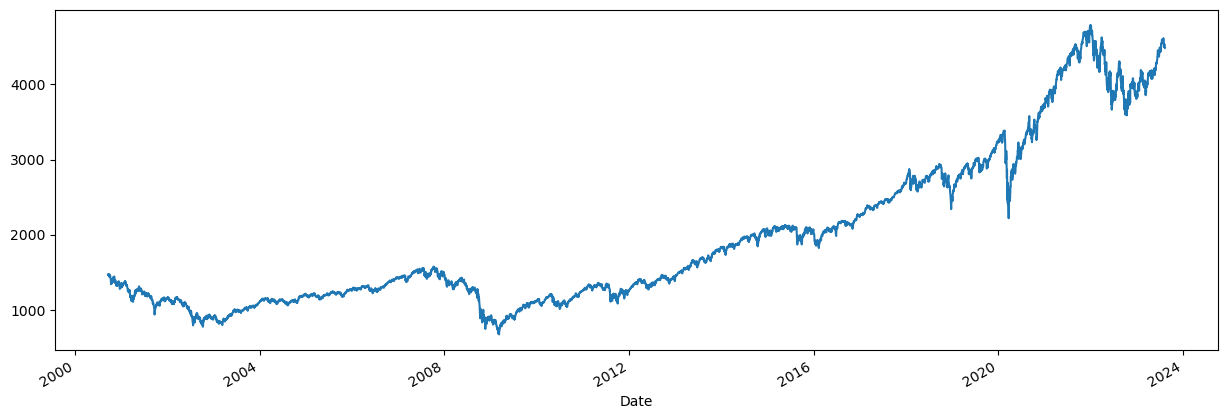

In [35]:
data = yf.download('ES=F')
data['Close'].plot()

# Strategies

#### EWMAC

In [36]:
def ewmac_forecast_scalar(Lfast, Lslow):
    """
    Function to return the forecast scalar (table 49 of the book)

    Only defined for certain values
    """
    #fsdict=dict(l2_8=10.6, l4_16=7.5, l8_32=5.3, l16_64=3.75, l32_128=2.65, l64_256=1.87)
    fsdict=dict(l2_8=16, l4_16=11, l8_32=7.5, l16_64=5.5, l32_128=4.0, l64_256=3.2)

    lkey="l%d_%d" % (Lfast, Lslow)

    if lkey in fsdict:
        return fsdict[lkey]
    else:
        print ("Warning: No scalar defined for Lfast=%d, Lslow=%d, using default of 1.0" % (Lfast, Lslow))
        return 1.0
    
def ewmac(close, Lfast, vol_lookback=25):
    
    Lslow=4*Lfast
    
    fast_ewma=close.ewm(span=Lfast).mean()
    slow_ewma=close.ewm(span=Lslow).mean()
    raw_ewmac=fast_ewma - slow_ewma
    
    stdev_returns=(close - close.shift(1)).ewm(span=vol_lookback).std()
    vol_adj_ewmac=raw_ewmac/stdev_returns
    f_scalar=ewmac_forecast_scalar(Lfast, Lslow)
    forecast=vol_adj_ewmac*f_scalar
    forecast = np.minimum(20,np.maximum(forecast,-20))
    
    name = f'EWMAC_{Lfast}_{vol_lookback}'
    return forecast.rename(name), name

In [37]:
all_forecasts = {}

In [38]:
import itertools
sims = []
Lfasts = [8,16,32,64]
vol_lookbacks = [25]
combinations = list(itertools.product(*[Lfasts, vol_lookbacks]))
for c in combinations:
    Lfast, vol_lookback = c
    ewmac_forecast, name = ewmac(data.Close, Lfast, vol_lookback)
    print(Lfast, abs(ewmac_forecast).median())
    all_forecasts[name] = ewmac_forecast
    sims.append((ewmac_forecast, name))

8 10.54576593017342
16 10.814999241572131
32 12.244765979332731
64 15.331184088863811


### Breakout

In [39]:
def breakout(price, lookback=10, smooth=None):
    
    fsdict=dict(l_8=0.7, l_16=0.85, l_32=0.9, l_64=0.9)
    
    if smooth is None:
        smooth = max(int(lookback / 4.0), 1)

    assert smooth < lookback

    roll_max = price.rolling(lookback, min_periods=int(min(len(price), np.ceil(lookback / 2.0)))).max()
    roll_min = price.rolling(lookback, min_periods=int(min(len(price), np.ceil(lookback / 2.0)))).min()

    roll_mean = (roll_max + roll_min) / 2.0

    output = 40.0 * ((price - roll_mean) / (roll_max - roll_min))
    forecast = output.ewm(span=smooth, min_periods=np.ceil(smooth / 2.0)).mean()
    
    lkey=f'l_{lookback}'
    forecast = forecast * fsdict[lkey]
    forecast = np.minimum(20,np.maximum(forecast,-20))
    name = f'Breakout_{lookback}'
    return forecast.rename(name), name

In [40]:
sims = []
lookbacks = [8,16,32,64]
for lookback in lookbacks:
    bo_forecast, name = breakout(data.Close, lookback = lookback)
    print(abs(bo_forecast).expanding().median().mean())
    all_forecasts[name] = bo_forecast
    sims.append((bo_forecast, name))

10.265333600995056
11.077492612998798
11.172753570721069
10.383875491324268


### Skew

In [41]:
def skew_strategy(price, lookback = 10):
    price = price.fillna(method='ffill')
    skew_returns=(price - price.shift(1)).rolling(window=lookback).skew()
    long_term_skew = (price - price.shift(1)).rolling(window=250*10, min_periods=30).skew()
    
    stdev_returns = (price - price.shift(1)).ewm(span=vol_lookback).std()
    
    forecast = (skew_returns - long_term_skew) / skew_returns.ewm(span=vol_lookback).std()
    forecast = forecast.ewm(span=lookback, min_periods=np.ceil(lookback/2.0)).mean()
    
    lkey=f'l_{lookback}'
    fsdict=dict(l_8=16, l_16=12, l_32=9, l_64=5)
    forecast = forecast * fsdict[lkey]
    forecast = np.minimum(20,np.maximum(forecast,-20))
    name = f'Skew_{lookback}'
    return forecast.rename(name), name

In [42]:
sims = []
lookbacks = [8,16,32,64]
for lookback in lookbacks:
    skew_forecast, name = skew_strategy(data.Close, lookback = lookback)
    print(abs(skew_forecast).median())
    all_forecasts[name] = skew_forecast
    sims.append((skew_forecast, name))

11.259011604062312
10.88151426734047
11.791855607694632
11.501246046651957


In [43]:
df_forecasts

,EWMAC_8_25,EWMAC_16_25,EWMAC_32_25,EWMAC_64_25,Breakout_8,Breakout_16,Breakout_32,Breakout_64,Skew_8,Skew_16,Skew_32,Skew_64
Date,,,,,,,,,,,,
2000-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-20,0.031504,0.017944,0.007685,0.003305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-21,-0.109343,-0.030504,-0.009181,-0.003275,-8.909091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-22,-0.313866,-0.105258,-0.035970,-0.013877,-10.818182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,11.128042,20.000000,20.000000,20.000000,-7.354772,-7.404377,8.999530,14.976961,17.872066,14.831821,20.0,20.0
2023-08-08,9.481753,20.000000,20.000000,20.000000,-8.500232,-8.849493,7.855315,14.505373,19.426174,15.194565,20.0,20.0
2023-08-09,6.582988,20.000000,20.000000,20.000000,-12.166744,-12.109696,5.892698,13.807057,20.000000,16.536536,20.0,20.0


In [44]:
df_forecasts = pd.concat([all_forecasts[k] for k,v in all_forecasts.items()], axis=1)

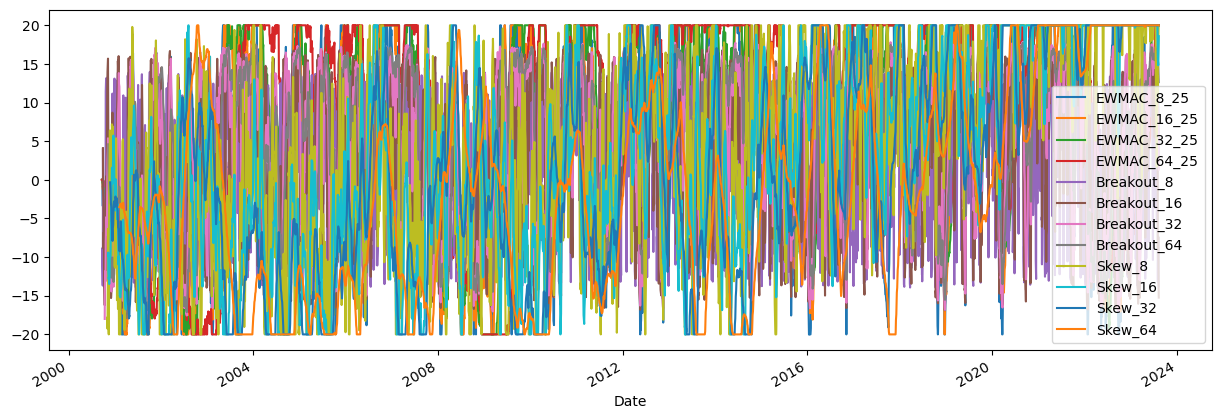

In [45]:
df_forecasts.plot();

## Correlation Plot

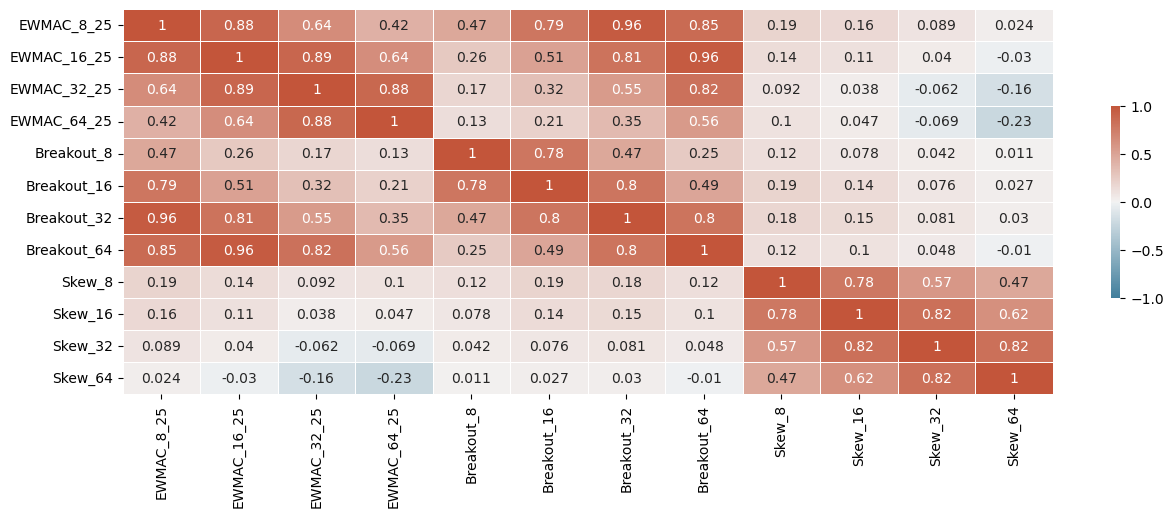

In [46]:
import seaborn as sns
corr = df_forecasts.corr()
f, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1,vmin=-1, center=0,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

# Performance

Let us have a look at how the Carver strategies perform. First we will assume we take a binary position (+1/-1), thereby ignoring the scaled forecast. <br>
This is not the recommendation of Carver. He suggests to take a position proportional to the forecast. We will look at this later.

### Binary

In [56]:
binary_performance = pd.DataFrame([1+((np.sign(df_forecasts[col]).shift(1)) * data['Close'].pct_change()).cumsum() for col in df_forecasts.columns]).T
binary_performance.columns = df_forecasts.columns

In [58]:
#benchmark:
bm = data['Close'].copy()
bm = bm[binary_performance.first_valid_index():]
bm/=bm[0]

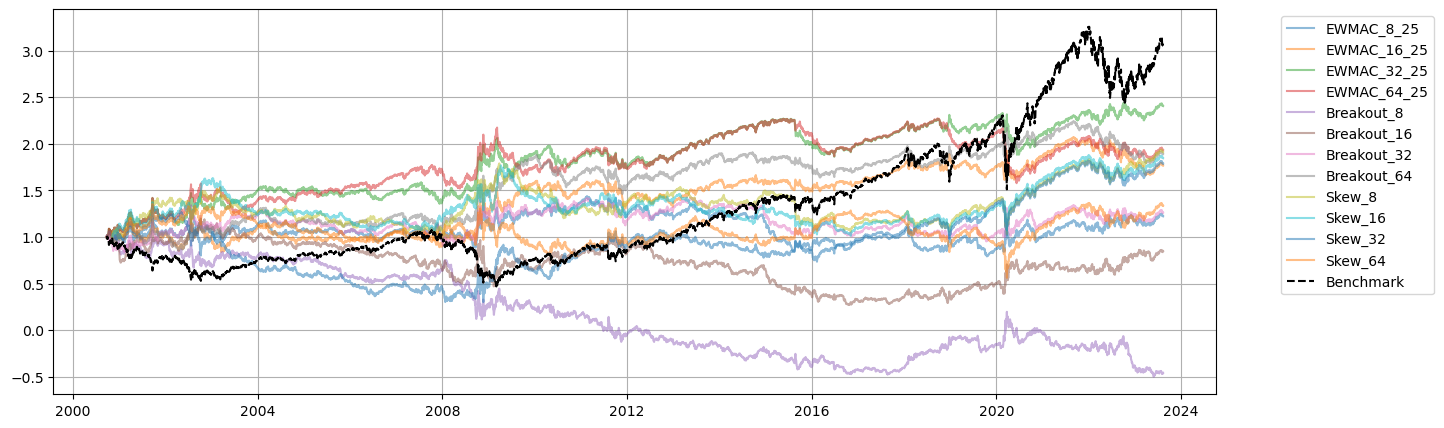

In [60]:
fig, ax = plt.subplots()
for col in binary_performance.columns:
    plt.plot(binary_performance[col], label=col, alpha=0.5)
plt.plot(bm, label='Benchmark', color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True)

### Scaled